# Group7 Project Notebook — Tinder Data Exploration
Structure:

1. Introduction & Dataset Overview
2. Data Loading
3. Safe Cleaning
4. Feature Engineering
5. Exploratory Visualizations (consistent modern colorful theme)

In [3]:
# ===================================
# Global Theme and FT Palette Setup
# ===================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import statsmodels.formula.api as smf
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import plotly.figure_factory as ff

# FT Palette — consistent across all visualizations
FT_RED   = "#C3423F"
FT_BLUE  = "#0072B2"
FT_PINK  = "#CC79A7"
FT_GREEN = "#009E73"
FT_GREY  = "#6F6F6F"
GRID     = "#D9D9D9"
TEXT     = "#2b2b2b"

# Full FT palette 
FT_PALETTE = [FT_RED, FT_BLUE, FT_PINK, FT_GREEN, FT_GREY, GRID, TEXT]

# ---------- seaborn theme ----------
sns.set_theme(
    style='whitegrid',
    context='notebook',
    palette=FT_PALETTE   # <-- Use FT palette globally
)

plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.titleweight'] = 'bold'

# ---------- plotly theme ----------
pio.templates.default = "plotly_white"
px.defaults.color_discrete_sequence = FT_PALETTE  # <-- FT palette globally

c:\Users\wrqib\my-project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

import os
os.makedirs("images", exist_ok=True)

def save_fig(name):
    path = f"images/{name}.png"
    plt.savefig(path, dpi=300, bbox_inches="tight")
    print(f"Saved: {path}")


## 1) Load Cleaned Dataset 

In [4]:
DATA_PATH = r'C:\Users\wrqib\my-project\Data Viz\archive(2)\Tinder_Data_v3_Clean_Edition.csv'
data = pd.read_csv(DATA_PATH)
print('Loaded data shape:', data.shape)
data.head()

Loaded data shape: (1209, 31)


,_id,sum_app_opens,no_of_days,nrOfConversations,longestConversation,longestConversationInDays,averageConversationLength,averageConversationLengthInDays,medianConversationLength,medianConversationLengthInDays,...,cityName,country,createDate,education,gender,interestedIn,instagram,spotify,jobTitle,user_age
0,00b74e27ad1cbb2ded8e907fcc49eaaf,6839,477,739,133,684,8.56,10.24,3,0.081134,...,Trondheim,Norway,2016-01-01,Has high school and/or college education,M,F,False,False,unknown,40
1,024610702baf540af5637873cd1534e9,26280,1197,464,36,622,4.50,3.97,2,0.000069,...,Richmond,USA,2016-07-12,Has high school and/or college education,M,F,False,False,unknown,19
2,0a5e3dd8489fe67485ddb7d6adb26ebd,3196,249,303,33,295,4.25,3.47,2,0.033715,...,unknown,unknown,2019-07-01,Has no high school or college education,M,F,False,False,unknown,21
3,048dd37565ad9cbc24c163ffedffbf58,2077,158,47,28,130,7.89,5.88,6,0.643727,...,Edmonton,Canada,2019-09-25,Has no high school or college education,M,F,False,False,unknown,21
4,0eb998fdde77f9c123c07eace18a5cc1,11946,715,809,444,198,6.82,1.92,3,0.091771,...,unknown,unknown,2017-11-17,Has no high school or college education,M,F,True,False,Research Assistant,21


## 2) Data Cleaning


In [5]:
data_clean = data.copy()
data_clean['birthDate'] = pd.to_datetime(data['birthDate'])
data_clean['createDate'] = pd.to_datetime(data['createDate'])
data_clean['gender'] = data['gender'].astype('category')
data_clean['education'] = data['education'].astype('category')
data_clean['interestedIn'] = data['interestedIn'].astype('category')
data_clean['country'] = data['country'].astype('category')
data_clean['jobTitle'] = data['jobTitle'].astype('string')
print(data_clean.duplicated().sum())
print(data_clean.isna().sum().sum())

0
0


Numerical columns: ['sum_app_opens', 'no_of_days', 'nrOfConversations', 'longestConversation', 'longestConversationInDays', 'averageConversationLength', 'averageConversationLengthInDays', 'medianConversationLength', 'medianConversationLengthInDays', 'nrOfOneMessageConversations', 'percentOfOneMessageConversations', 'nrOfGhostingsAfterInitialMessage', 'no_of_matches', 'no_of_msgs_sent', 'no_of_msgs_received', 'swipe_likes', 'swipe_passes', 'ageFilterMin', 'ageFilterMax', 'user_age']


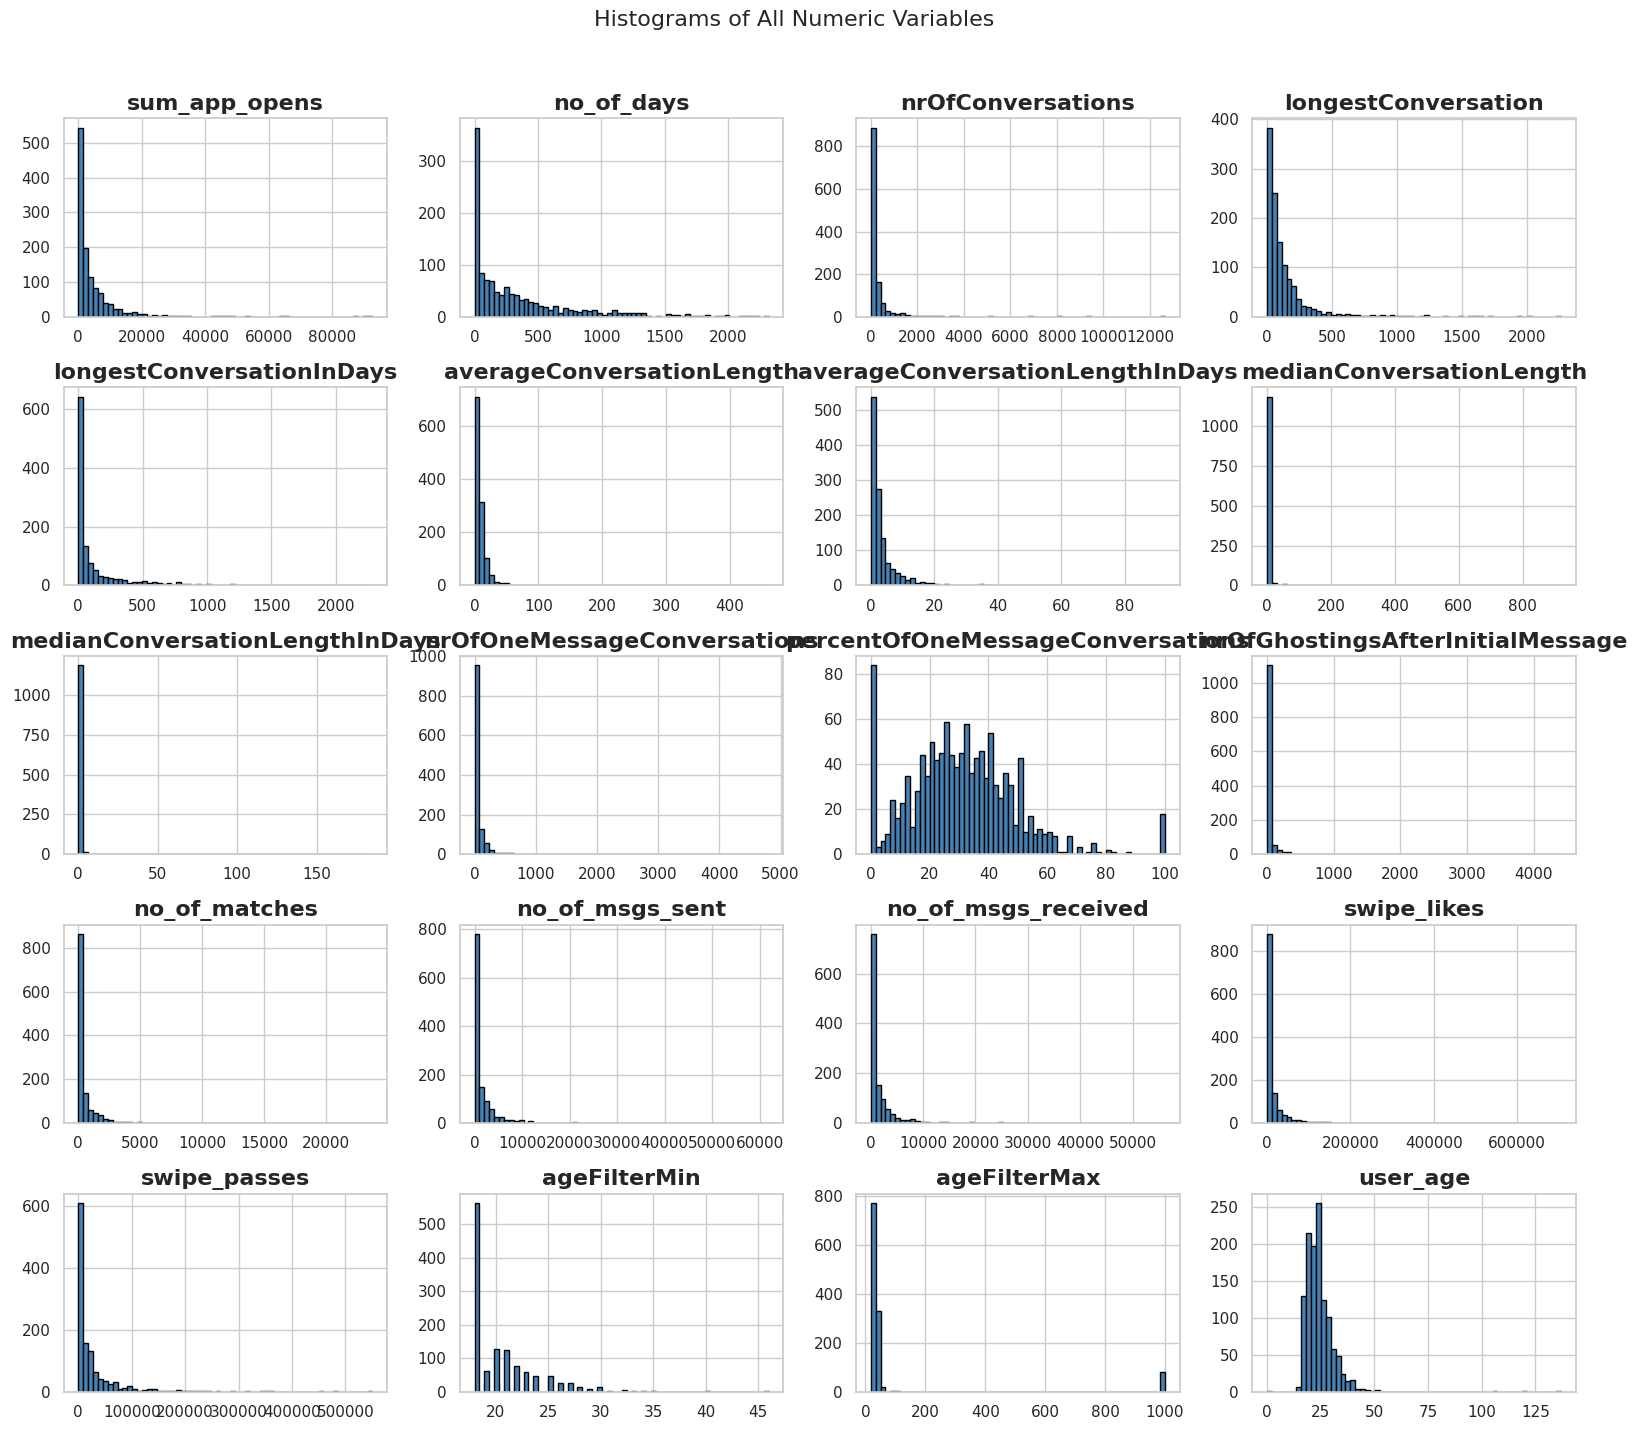

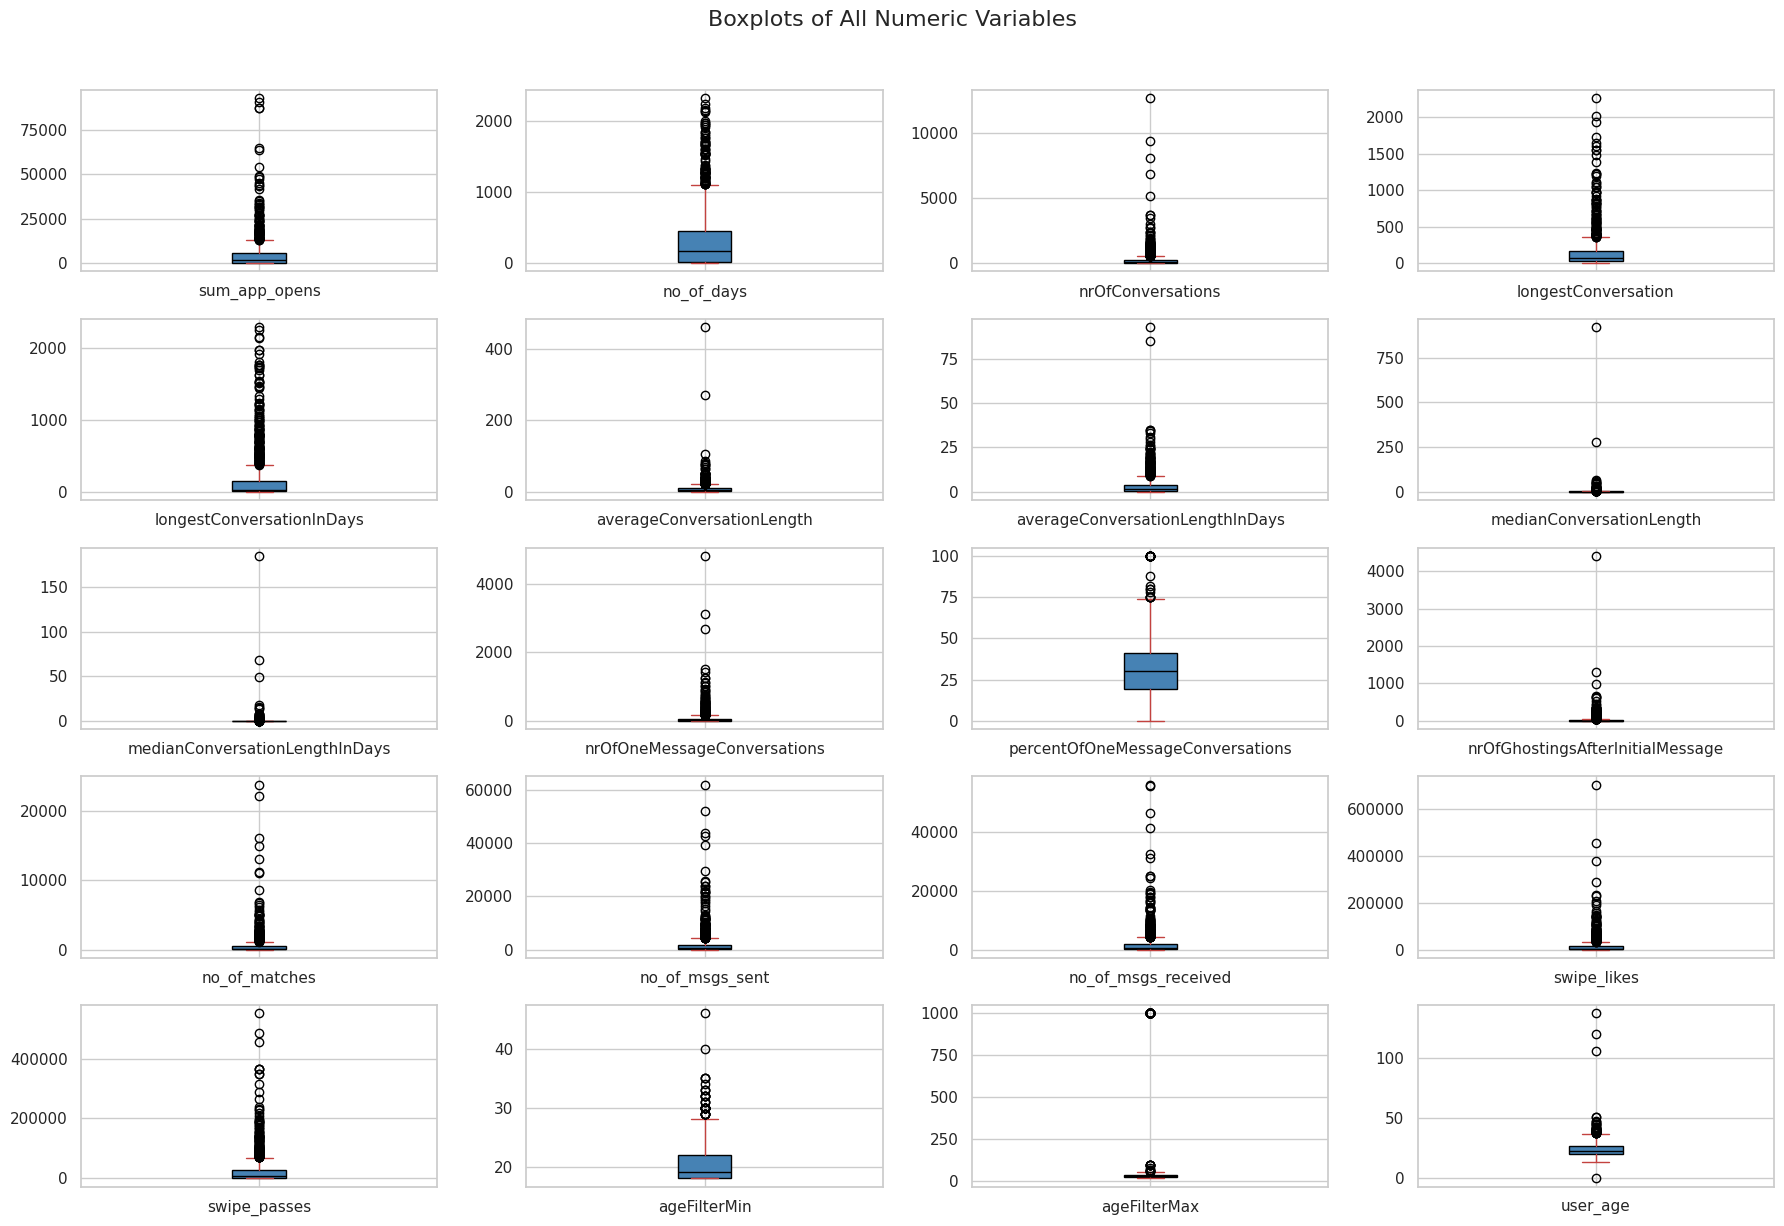

In [10]:
#EXPLORATORY VISUALIZATION --- NOT FOR PUBLICATION

data = data_clean.copy()
num_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Numerical columns: {num_cols}")

data[num_cols].hist(
    bins=60, 
    figsize=(16, 14),
    layout=(-1, 4),  # auto layout with 4 columns per row
    edgecolor='black',
    color='steelblue'
)

plt.suptitle("Histograms of All Numeric Variables", y=1.02, fontsize=16)
plt.tight_layout()
#save_fig('figure_1')
plt.show()

data.select_dtypes(include=['number']).plot(
    kind='box',
    subplots=True,
    layout=(-1, 4),
    figsize=(18, 12),
    patch_artist=True,
    boxprops=dict(facecolor='steelblue', color='black'),
    medianprops=dict(color='black'),
)
plt.suptitle("Boxplots of All Numeric Variables", y=1.02, fontsize=16)
plt.tight_layout()
#save_fig('figure_1')
plt.show()

In [11]:
data = data[data["user_age"] < 90]
data = data[data["user_age"] > 17]
data = data.dropna()


In [12]:
print(data['ageFilterMax'].describe())
print(data['ageFilterMin'].describe())

count    1181.000000
mean       93.523285
std       236.319761
min        18.000000
25%        26.000000
50%        30.000000
75%        38.000000
max      1000.000000
Name: ageFilterMax, dtype: float64
count    1181.000000
mean       20.479255
std         3.338875
min        18.000000
25%        18.000000
50%        19.000000
75%        22.000000
max        46.000000
Name: ageFilterMin, dtype: float64


In [13]:
data = data[data['ageFilterMax'] < 100]
data = data.dropna()
print(data['ageFilterMax'].describe())

count    1104.000000
mean       31.930254
std         8.709143
min        18.000000
25%        26.000000
50%        30.000000
75%        36.000000
max        97.000000
Name: ageFilterMax, dtype: float64


## 3) Feature Engineering
Construct derived columns used in visualizations (age gaps, opens per day, logs where helpful).

In [18]:
data['upper_age_gap'] = data['ageFilterMax'] - data["user_age"] 
data['lower_age_gap'] = data["user_age"] - data['ageFilterMin']
data['total_age_interval'] = data['upper_age_gap'] - data['lower_age_gap']

agg = (data.groupby('gender', dropna=False)
         .agg(median_upper=('upper_age_gap','median'),
              median_lower=('lower_age_gap','median'))
         .reset_index())

agg['gender'] = agg['gender'].replace({'M': 'Male', 'F': 'Female'})

agg['left']  = -agg['median_lower']
agg['right'] =  agg['median_upper']

C:\Users\wrqib\AppData\Local\Temp\ipykernel_13264\2275770827.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = (data.groupby('gender', dropna=False)
C:\Users\wrqib\AppData\Local\Temp\ipykernel_13264\2275770827.py:10: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  agg['gender'] = agg['gender'].replace({'M': 'Male', 'F': 'Female'})


## 4) Exploratory Visualizations

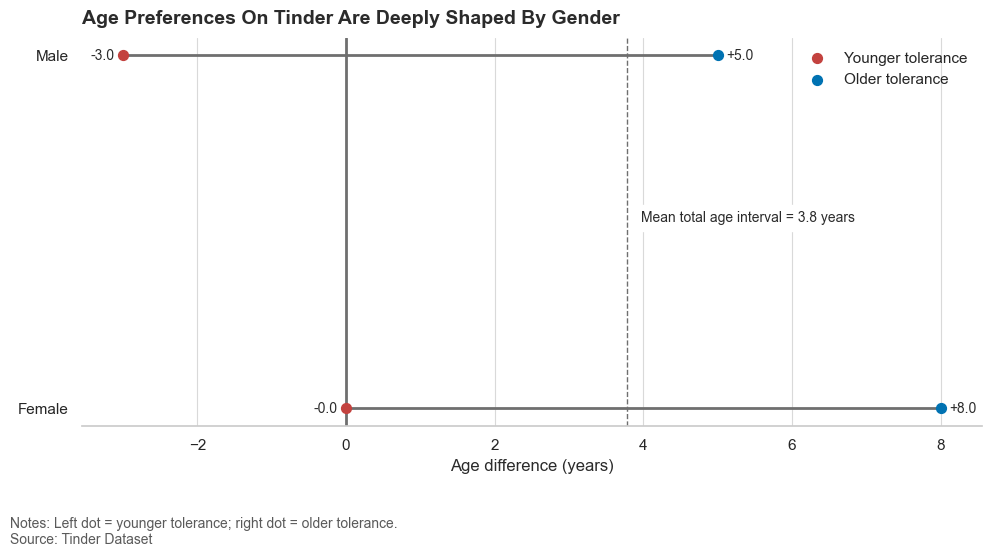

In [33]:
# ================================================================
# 1st Visualization — Age Gaps Preferences using clean data v3 (FT palette)
# ================================================================



# --- Figure ---
sns.set_theme(style="whitegrid", context="notebook")
fig, ax = plt.subplots(figsize=(10, 5))

# Grid styling
ax.xaxis.grid(True, color=GRID, lw=0.8)
ax.yaxis.grid(False)

# Zero line
ax.axvline(0, color=FT_GREY, lw=2)

# Mean interval line
mean_gap = data["total_age_interval"].mean()
ax.axvline(mean_gap, color=FT_GREY, lw=1, ls="dashed")

ax.annotate(
    f"Mean total age interval = {mean_gap:.1f} years",
    xy=(mean_gap, 0.5),
    xytext=(10, 10),
    textcoords="offset points",
    ha="left",
    va="center",
    fontsize=10,
    color=TEXT,
    backgroundcolor="white"
)

# Horizontal lines per gender
ax.hlines(
    y=agg["gender"], xmin=agg["left"], xmax=agg["right"],
    color=FT_GREY, lw=2
)

# Endpoints using FT palette
ax.scatter(agg["left"],  agg["gender"], s=50, color=FT_RED,  zorder=3, label="Younger tolerance")
ax.scatter(agg["right"], agg["gender"], s=50, color=FT_BLUE, zorder=3, label="Older tolerance")

# Annotate values
for _, r in agg.iterrows():
    ax.annotate(
        f"-{r['median_lower']:.1f}",
        xy=(r["left"], r["gender"]),
        xytext=(-6, 0),
        textcoords="offset points",
        ha="right", va="center",
        fontsize=10,
        color=TEXT
    )
    ax.annotate(
        f"+{r['median_upper']:.1f}",
        xy=(r["right"], r["gender"]),
        xytext=(6, 0),
        textcoords="offset points",
        ha="left", va="center",
        fontsize=10,
        color=TEXT
    )

# Labels / Title
ax.set_xlabel("Age difference (years)", color=TEXT)
ax.set_ylabel("")
ax.set_title(
    "Age Preferences On Tinder Are Deeply Shaped By Gender",
    loc="left",
    pad=10,
    color=TEXT,
    fontweight="bold",
    fontsize = 14
)

# Clean up spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

# Legend
ax.legend(frameon=False, loc="upper right")

# Notes
plt.figtext(
    0.01, -0.05,
    "Notes: Left dot = younger tolerance; right dot = older tolerance.\nSource: Tinder Dataset",
    ha="left",
    va="top",
    fontsize=10,
    color="#5A5A5A"
)

plt.tight_layout()
#save_fig('figure_2')
plt.show()


In [20]:
# ============================================
# Job Title Embeddings
# ============================================

df = data.copy()
# Ensure job titles are strings
jobtitles = df["jobTitle"].astype(str).tolist()

# Load embedding model
model = SentenceTransformer("all-mpnet-base-v2")

# Compute embeddings
embeddings = model.encode(jobtitles, show_progress_bar=True)

# Save into df
df["embedding"] = [vec.tolist() for vec in embeddings]

print("Embedding generation completed.")
print("Embedding shape:", embeddings.shape)
df.head()


Batches: 100%|██████████| 35/35 [00:09<00:00,  3.76it/s]


Embedding generation completed.
Embedding shape: (1104, 768)


,_id,sum_app_opens,no_of_days,nrOfConversations,longestConversation,longestConversationInDays,averageConversationLength,averageConversationLengthInDays,medianConversationLength,medianConversationLengthInDays,...,gender,interestedIn,instagram,spotify,jobTitle,user_age,upper_age_gap,lower_age_gap,total_age_interval,embedding
0,00b74e27ad1cbb2ded8e907fcc49eaaf,6839,477,739,133,684,8.56,10.24,3,0.081134,...,M,F,False,False,unknown,40,-5,19,-24,"[0.051387980580329895, 0.008863350376486778, -..."
1,024610702baf540af5637873cd1534e9,26280,1197,464,36,622,4.50,3.97,2,0.000069,...,M,F,False,False,unknown,19,10,1,9,"[0.051387980580329895, 0.008863350376486778, -..."
2,0a5e3dd8489fe67485ddb7d6adb26ebd,3196,249,303,33,295,4.25,3.47,2,0.033715,...,M,F,False,False,unknown,21,3,1,2,"[0.051387980580329895, 0.008863350376486778, -..."
3,048dd37565ad9cbc24c163ffedffbf58,2077,158,47,28,130,7.89,5.88,6,0.643727,...,M,F,False,False,unknown,21,4,1,3,"[0.051387980580329895, 0.008863350376486778, -..."
4,0eb998fdde77f9c123c07eace18a5cc1,11946,715,809,444,198,6.82,1.92,3,0.091771,...,M,F,True,False,Research Assistant,21,6,3,3,"[0.03389490023255348, 0.042212653905153275, -0..."


In [21]:
# ============================================
# K-Means Clustering for Job title
# ============================================

# Build matrix for clustering
X = np.vstack(df["embedding"].values)
print("The shape of X is", X.shape)
X_unit = normalize(X)  # Normalize for cosine-like clustering

def find_best_k(X, k_min=2, k_max=17):
    scores = {}
    for k in range(k_min, k_max + 1):
        km = KMeans(n_clusters=k, random_state=25, n_init="auto")
        labels = km.fit_predict(X)
        score = silhouette_score(X, labels)
        scores[k] = score
        print(f"k={k}: silhouette={score:.4f}")
    best_k = max(scores, key=scores.get)
    return best_k, scores

best_k, scores = find_best_k(X_unit)
print("Best K:", best_k)

# Fit final clustering model
km = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
df["Job_Cluster"] = km.fit_predict(X_unit)

df["Job_Cluster"].value_counts()


The shape of X is (1104, 768)
k=2: silhouette=0.6622
k=3: silhouette=0.6940
k=4: silhouette=0.6752
k=5: silhouette=0.6815
k=6: silhouette=0.6752
k=7: silhouette=0.6801
k=8: silhouette=0.6750
k=9: silhouette=0.6791
k=10: silhouette=0.6813
k=11: silhouette=0.6816
k=12: silhouette=0.6827
k=13: silhouette=0.6827
k=14: silhouette=0.6853
k=15: silhouette=0.6877
k=16: silhouette=0.6919
k=17: silhouette=0.6914
Best K: 3


Job_Cluster
1    688
0    219
2    197
Name: count, dtype: int64

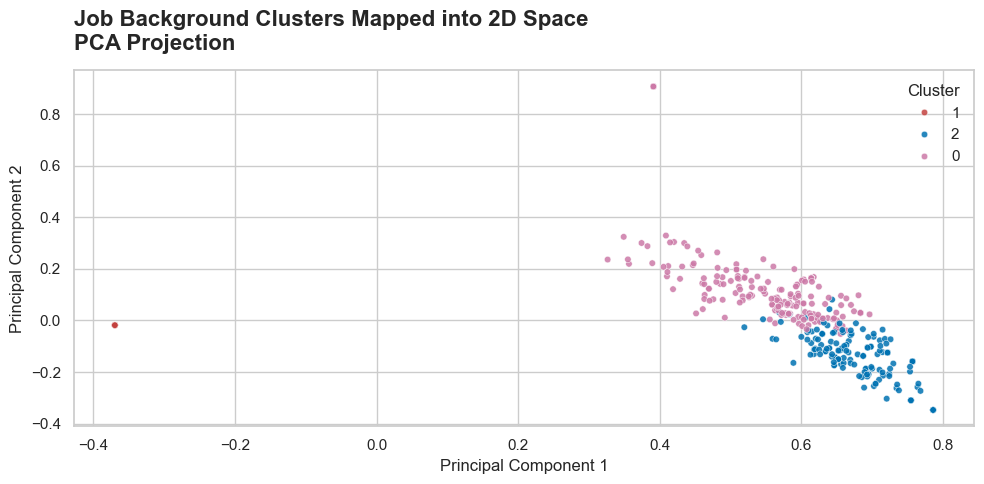

In [24]:
# ================================================================
# Intermediary Exploratory Visualization — PCA Visualization of Job Clusters (Not for Publication)
# ================================================================

sns.set_theme(style="whitegrid", context="notebook")

# PCA for 2D visualization
pca = PCA(n_components=2)
coords = pca.fit_transform(X_unit)

pca_df = pd.DataFrame({
    "PC1": coords[:, 0],
    "PC2": coords[:, 1],
    "Cluster": df["Job_Cluster"].astype(str)
})

plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue="Cluster",
    palette=FT_PALETTE[:3],
    s=22,
    alpha=0.85
)

plt.title(
    "Job Background Clusters Mapped into 2D Space\nPCA Projection",
    fontsize=16,
    fontweight="bold",
    loc="left",
    pad=15
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.legend(
    title="Cluster",
    frameon=False,
    loc="best"
)

plt.tight_layout()
#save_fig('figure_3')
plt.show()


C:\Users\wrqib\AppData\Local\Temp\ipykernel_13264\48088013.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("Job_Cluster")["no_of_matches"]
C:\Users\wrqib\AppData\Local\Temp\ipykernel_13264\48088013.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


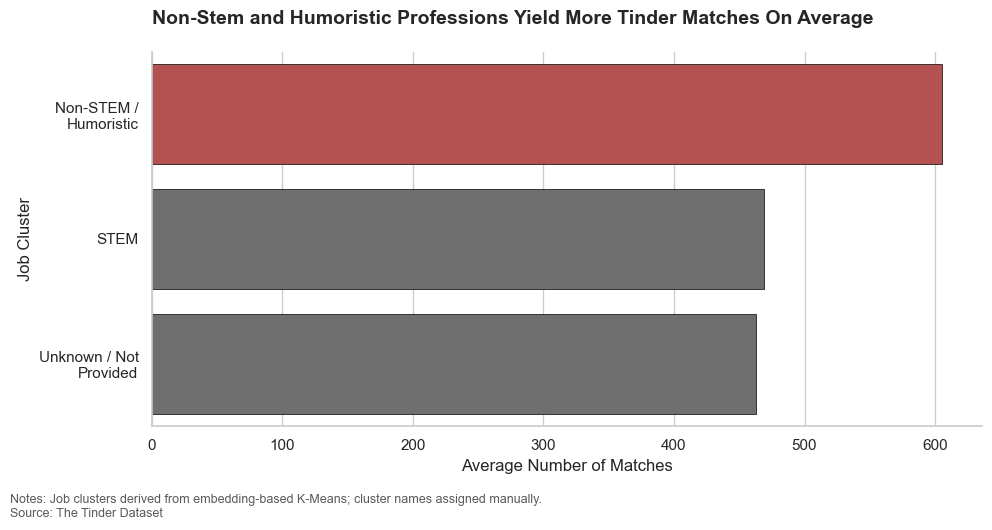

In [34]:
# ==================================================
# 2nd Visulization — Job Clusters vs Average Matches
# ==================================================

# Replace cluster labels with human-readable names
df["Job_Cluster"] = df["Job_Cluster"].replace({
    0: "Non-STEM / Humoristic",
    1: "Unknown / Not Provided",
    2: "STEM"
}).astype("category")

# Compute average matches by cluster
prof_graph = (
    df.groupby("Job_Cluster")["no_of_matches"]
      .mean()
      .reset_index()
)

# Wrap labels for cleaner y axis
prof_graph["Job_Cluster"] = prof_graph["Job_Cluster"].str.wrap(20)

#Palette for this specific visualisation, emphasize central findings:
palette = ["#C3423F", "#6F6F6F", "#6F6F6F"]

plt.figure(figsize=(10,5))
sns.barplot(
    data=prof_graph,
    y="Job_Cluster",
    x="no_of_matches",
    palette = palette,        
    edgecolor="black",
    linewidth=0.5
)

plt.title("Non-Stem and Humoristic Professions Yield More Tinder Matches On Average",
          fontsize=14, weight="bold", loc="left", pad=20)
plt.xlabel("Average Number of Matches")
plt.ylabel("Job Cluster")

sns.despine(left=False, bottom=False)

plt.figtext(
    0.01, -0.05,
    "Notes: Job clusters derived from embedding-based K-Means; cluster names assigned manually.\n"
    "Source: The Tinder Dataset",
    ha="left",
    fontsize=9,
    color="#5A5A5A"
)

plt.tight_layout()
#save_fig('figure_4')
plt.show()


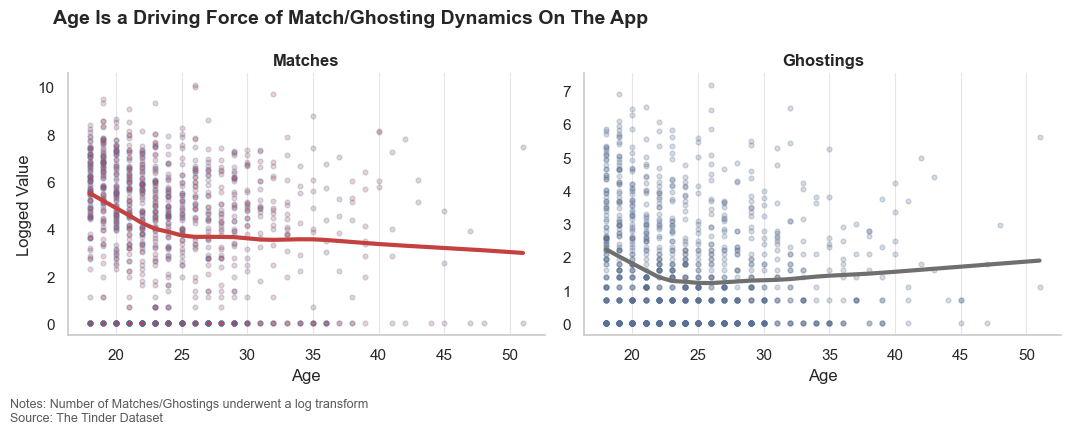

In [41]:
# ================================================================
# 3rd Visulization — Age Effects on Matches & Ghosting — FacetGrid
# ================================================================

df_reg = data.copy()

# Prepare data for regression
data2 = df_reg[['user_age', 'no_of_matches', 'nrOfGhostingsAfterInitialMessage']].copy()
data2['log_no_of_matches'] = np.log1p(data2['no_of_matches'])
data2['log_no_of_ghosting'] = np.log1p(data2['nrOfGhostingsAfterInitialMessage'])

df_long = data2.melt(
    id_vars='user_age',
    value_vars=['log_no_of_matches', 'log_no_of_ghosting'],
    var_name='Outcome',
    value_name='Value'
)

df_long['Outcome'] = df_long['Outcome'].replace({
    'log_no_of_matches': 'Matches',
    'log_no_of_ghosting': 'Ghostings'
})

# FT palette
COLOR_MATCH = FT_RED
COLOR_GHOST = FT_GREY  

# FacetGrid ------------------------------
g = sns.FacetGrid(
    df_long,
    col='Outcome',
    sharey=False,
    sharex=True,
    height=4,
    aspect=1.35
)

# Draw regression (same color first, overwrite later)
g.map(
    sns.regplot,
    "user_age",
    "Value",
    lowess=True,
    scatter_kws={'alpha': 0.25, 's': 12},
    line_kws={'lw': 3}
)

# Assign FT colors per facet
for ax, outcome in zip(g.axes.flatten(), df_long['Outcome'].unique()):
    if outcome == "Matches":
        color = COLOR_MATCH
    else:
        color = COLOR_GHOST
    # Recolor the regression line + points
    for artist in ax.lines:
        artist.set_color(color)
    for collection in ax.collections:
        collection.set_facecolor(color)

# Titles / axes
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Age", "Logged Value")

# Clean style
for ax in g.axes.flatten():
    sns.despine(ax=ax)
    ax.grid(True, axis='x', color="#E6E6E6", lw=0.8)
    ax.grid(False, axis='y')

# Main title ------------------------------
plt.subplots_adjust(top=0.82)
g.fig.suptitle(
    "Age Is a Driving Force of Match/Ghosting Dynamics On The App",
    fontsize=14,
    weight='bold',
    x=0.05,
    ha='left'
)

plt.figtext(
    0.01, -0.05,
    "Notes: Number of Matches/Ghostings underwent a log transform \n"
    "Source: The Tinder Dataset",
    ha="left",
    fontsize=9,
    color="#5A5A5A"
)

#save_fig('figure_5')
plt.show()


C:\Users\wrqib\AppData\Local\Temp\ipykernel_13264\2603677804.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby('conv_length_bucket')['nrOfGhostingsAfterInitialMessage']
C:\Users\wrqib\AppData\Local\Temp\ipykernel_13264\2603677804.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


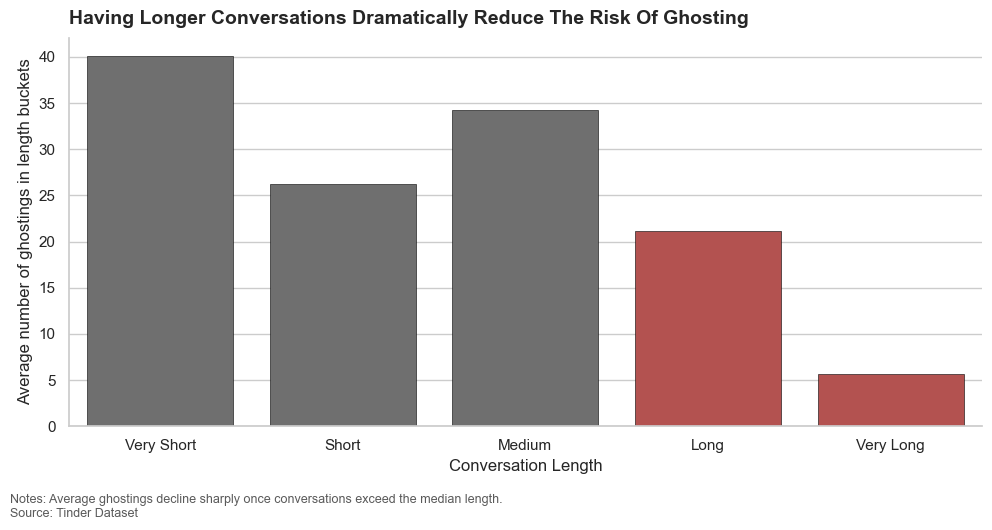

In [48]:
# ================================================================
# 6th Visualization — Ghosting Likelihood vs Conversation Depth
# ================================================================

# 1) Create conversation length buckets
data['conv_length_bucket'] = pd.qcut(
    data['averageConversationLength'],
    q=5,
    labels=["Very Short", "Short", "Medium", "Long", "Very Long"],
    duplicates='drop'
)

# 2) Compute mean ghosting in each bucket
ghost_plot = (
    data.groupby('conv_length_bucket')['nrOfGhostingsAfterInitialMessage']
        .mean()
        .reset_index()
)

# 3) Ensure correct ordering on the x-axis
order = ["Very Short", "Short", "Medium", "Long", "Very Long"]
ghost_plot['conv_length_bucket'] = pd.Categorical(
    ghost_plot['conv_length_bucket'],
    categories=order,
    ordered=True
)
ghost_plot = ghost_plot.sort_values('conv_length_bucket')

# 4) Use a smooth FT gradient from light grey → FT red
palette = ["#6F6F6F", "#6F6F6F", "#6F6F6F", "#C3423F", "#C3423F" ]
# 5) Plot
plt.figure(figsize=(10, 5))

sns.barplot(
    data=ghost_plot,
    x='conv_length_bucket',
    y='nrOfGhostingsAfterInitialMessage',
    palette=palette,
    edgecolor="black",
    linewidth=0.4
)

# More insightful title
plt.title(
    "Having Longer Conversations Dramatically Reduce The Risk Of Ghosting",
    fontsize=14,
    weight='bold',
    loc='left',
    pad=10
)

plt.xlabel("Conversation Length")
plt.ylabel("Average number of ghostings in length buckets")

sns.despine()

# Notes
plt.figtext(
    0.01, -0.05,
    "Notes: Average ghostings decline sharply once conversations exceed the median length.\n"
    "Source: Tinder Dataset",
    ha="left",
    fontsize=9,
    color="#5A5A5A"
)

plt.tight_layout()
#save_fig('figure_6')
plt.show()


In [ ]:
# ================================================================
# 5th Visualization — Conversation Length Distribution by Gender — KDE
# ================================================================
# Copy dataset and keep only valid entries
df_len = df.copy()
df_len = df_len[df_len["medianConversationLengthInDays"].notna()]

# Remove extreme outliers above the 99th percentile
q99 = df_len["medianConversationLengthInDays"].quantile(0.99)
df_len = df_len[df_len["medianConversationLengthInDays"] <= q99]

# Overall median for reference line
overall_median = df_len["medianConversationLengthInDays"].median()

# Prepare KDE groups by gender
groups = []
labels = []
for code, label in [("M", "Men"), ("F", "Women")]:
    vals = df_len.loc[df_len["gender"] == code, "medianConversationLengthInDays"]
    if not vals.empty:
        groups.append(vals)
        labels.append(label)

# Create KDE density plot without histogram or rug elements
fig = ff.create_distplot(
    groups,
    labels,
    show_hist=False,
    show_rug=False
)

# Apply FT / Economist palette
colors = [FT_BLUE, FT_PINK]  # Men, Women
for trace, col in zip(fig.data, colors):
    trace.update(line=dict(width=3, color=col))

# Add median reference line
fig.add_vline(
    x=overall_median,
    line_dash="dash",
    line_color="black",
    line_width=2
)

# Annotate the median
fig.add_annotation(
    x=overall_median,
    y=0.95,
    xref="x",
    yref="paper",
    text=f"Overall median: {overall_median:.2f} days",
    showarrow=False,
    yanchor="bottom",
    font=dict(size=12)
)

# Configure axes
fig.update_xaxes(
    title_text="Median conversation length (days)",
    range=[0, 5]
)
fig.update_yaxes(title_text="Density")

# Layout and title
fig.update_layout(
    template="simple_white",
    paper_bgcolor="white",
    plot_bgcolor="white",
    legend_title_text="Gender",
    title={
        "text": (
            "Most Tinder Conversations End Almost Immediately<br>"
        ),
        "x": 0,
        "xanchor": "left",
        "font": dict(size=22)
    },
    margin=dict(l=60, r=40, t=90, b=60)
)

# Footnote
fig.add_annotation(
    xref="paper",
    yref="paper",
    x=0.0,
    y=-0.20,
    showarrow=False,
    text="Long conversations above the 99th percentile are truncated for clarity.",
    font=dict(size=10)
)

fig.show()

#save_fig('figure_7')

In [114]:
# ================================================================
# 6th Visualization — Persona-Level Success Comparison (Bar Chart)
# ================================================================

import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Features used to identify usage personas
features = [
    "sum_app_opens",
    "no_of_days",
    "medianConversationLength",
    "longestConversationInDays",
    "nrOfConversations"
]

X = df[features].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Three personas identified via k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df.loc[X.index, "persona_cluster"] = kmeans.fit_predict(X_scaled)

df_success = df.dropna(subset=["persona_cluster"]).copy()

# Define the success metric depending on dataset contents
if "match_count" in df_success.columns:
    df_success["match_rate"] = (
        df_success["match_count"] /
        df_success["nrOfConversations"].clip(lower=1)
    )
    success_col = "match_rate"
    success_label = "Matches per conversation"
else:
    depth = df_success["medianConversationLength"]
    duration = df_success["longestConversationInDays"]
    df_success["quality_score"] = (
        depth.rank(pct=True) + duration.rank(pct=True)
    ) / 2
    success_col = "quality_score"
    success_label = "Conversation quality score"

# Average success within each persona
persona_success = (
    df_success
    .groupby("persona_cluster")[success_col]
    .mean()
    .rename_axis("persona_cluster")
    .reset_index(name="success")
)

# Labels for the personas
persona_name = {
    0: "Low-Engagement Browsers",
    1: "Deep Conversationalists",
    2: "Highly Active Explorers"
}
persona_success["persona_name"] = persona_success["persona_cluster"].map(persona_name)

# FT-inspired color palette
ft_palette = FT_PALETTE[:3]

# Sorted for visual clarity
persona_success_sorted = persona_success.sort_values("success", ascending=False)

# Plot
fig_success = px.bar(
    persona_success_sorted,
    x="success",
    y="persona_name",
    orientation="h",
    template="simple_white",
    color="persona_name",
    color_discrete_sequence=ft_palette,
    text="success"
)

fig_success.update_traces(
    texttemplate="%{x:.2f}",
    textposition="outside",
    marker_line_color="white",
    marker_line_width=1.4
)

fig_success.update_layout(
    title=dict(
        text=(
            "Highly Active Explorer Are The Most Successful Users Post-Matching<br>"
        ),
        x=0.05,
        font=dict(size=16)
    ),
    xaxis=dict(
        title=success_label,
        gridcolor="rgba(0,0,0,0.06)",
        range=[0, persona_success["success"].max() * 1.15]
    ),
    yaxis=dict(
        title="Persona",
        categoryorder="total descending"
    ),
    showlegend=False,
    plot_bgcolor="white",
    paper_bgcolor="white",
    margin=dict(l=160, r=40, t=80, b=60)
)

fig_success.show()


In [94]:
# ====================================================
# 7th Visualization — One-Message Conversation Rate by Age Band
# ====================================================

df_plot = df[['user_age', 'percentOfOneMessageConversations']].dropna()

age_bins   = [18, 25, 30, 40, 55, 100]
age_labels = ['18–24', '25–29', '30–39', '40–54', '55+']

df_plot['age_band'] = pd.cut(
    df_plot['user_age'],
    bins=age_bins,
    labels=age_labels,
    right=False
)

summary = (
    df_plot
    .groupby('age_band', observed=True)['percentOfOneMessageConversations']
    .mean()
    .reindex(age_labels)
    .reset_index(name='one_msg_rate')
)

if summary['one_msg_rate'].max() <= 1:
    summary['one_msg_rate'] *= 100

fig = go.Figure()

# stems
for _, row in summary.iterrows():
    fig.add_trace(go.Scatter(
        x=[0, row['one_msg_rate']],
        y=[row['age_band'], row['age_band']],
        mode='lines',
        line=dict(color=GRID, width=2),
        showlegend=False
    ))

# dots + labels (FT Red)
fig.add_trace(go.Scatter(
    x=summary['one_msg_rate'],
    y=summary['age_band'],
    mode='markers+text',
    marker=dict(
        size=12,
        color=FT_RED,
        line=dict(color='white', width=1)
    ),
    text=[f'{v:.1f}%' for v in summary['one_msg_rate']],
    textposition='middle right',
    textfont=dict(color=TEXT),
    showlegend=False
))

fig.update_layout(
    template='simple_white',
    title=(
        'Most Conversations Die After a Single Message<br>'
        '<sup>Average share of one-message conversations by age group</sup>'
    ),
    title_font=dict(color=TEXT),
    xaxis=dict(
        title='Share of conversations ending after 1 message (%)',
        range=[0, summary['one_msg_rate'].max() * 1.2],
        color=TEXT,
        gridcolor=GRID
    ),
    yaxis=dict(
        title='Age group',
        color=TEXT
    ),
    plot_bgcolor='white',
    paper_bgcolor='white',
    margin=dict(l=80, r=80, t=80, b=50)
)

fig.add_annotation(
    xref='paper', yref='paper',
    x=0.02, y=-0.25,
    text='Note: Across all age groups, roughly a third of conversations end after the first message.',
    showarrow=False,
    font=dict(size=10, color=FT_GREY)
)

fig.show()

#save_fig('figure_8')

C:\Users\wrqib\AppData\Local\Temp\ipykernel_13264\790718191.py:23: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



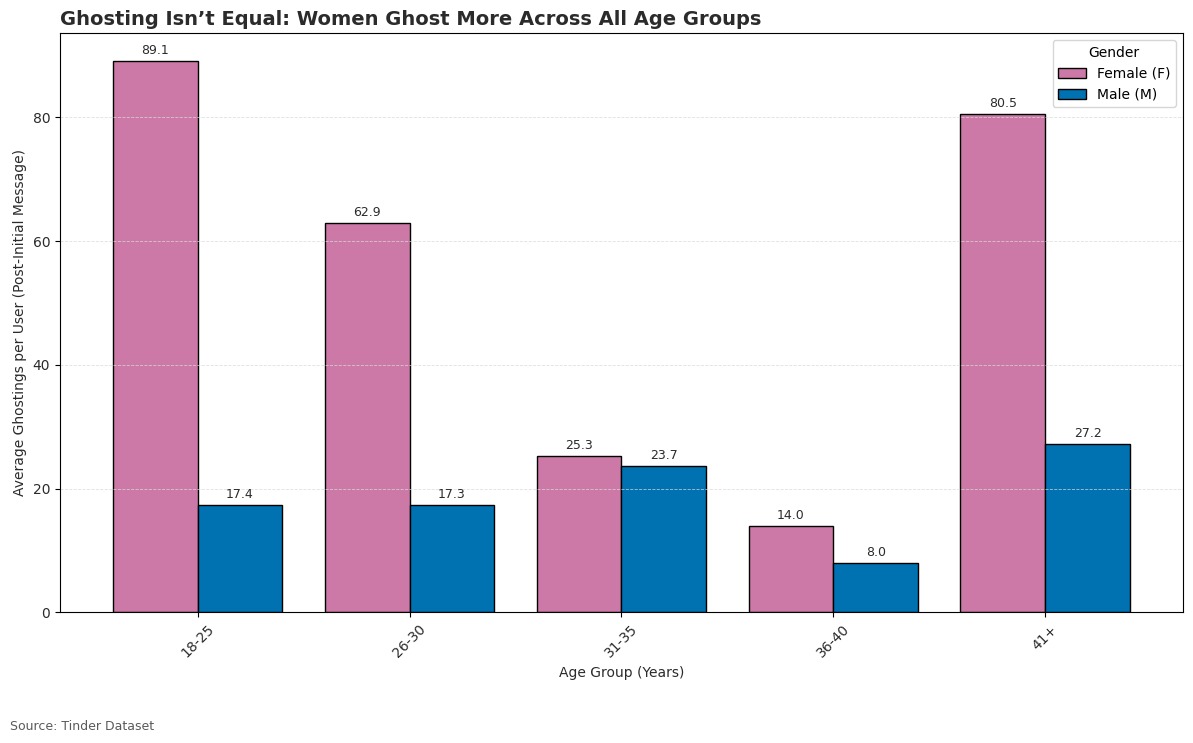

In [105]:
# ================================================================
# 8th Visualization — Ghosting Rate Across Age Groups (FT-Style Bar Chart)
# ================================================================
df_ghosting = df.copy()

# Create age bins
bins = [18, 25, 30, 35, 40, 99] 
labels = ['18-25', '26-30', '31-35', '36-40', '41+']

df_ghosting = df[df['gender'].isin(['M', 'F'])].copy()

df_ghosting['Age_Group'] = pd.cut(
    df_ghosting['user_age'], 
    bins=bins, 
    labels=labels, 
    right=True, 
    include_lowest=True
)

# Aggregation
df_ghosting_rate = (
    df_ghosting
    .groupby(['Age_Group', 'gender'])['nrOfGhostingsAfterInitialMessage']
    .mean()
    .unstack()
)

df_ghosting_rate.columns.name = None
df_ghosting_rate.rename(columns={'F': 'Female (F)', 'M': 'Male (M)'}, inplace=True)

# Plot
plt.style.use('default')
fig, ax = plt.subplots(figsize=(12, 7))

df_ghosting_rate.plot(
    kind='bar',
    ax=ax,
    color=[FT_PINK, FT_BLUE],   # Female = Pink, Male = Blue
    edgecolor='black',
    width=0.8
)

# Title
ax.set_title('Ghosting Isn’t Equal: Women Ghost More Across All Age Groups', fontsize=14, color=TEXT, loc = 'left', fontweight = 'bold')

# Axes
ax.set_ylabel('Average Ghostings per User (Post-Initial Message)', color=TEXT)
ax.set_xlabel('Age Group (Years)', color=TEXT)
ax.tick_params(axis='x', rotation=45, labelcolor=TEXT)
ax.tick_params(axis='y', labelcolor=TEXT)

# Grid
ax.grid(axis='y', linestyle='--', linewidth=0.6, color=GRID, alpha=0.8)

# Bar labels
for container in ax.containers:
    ax.bar_label(
        container,
        fmt='%.1f',
        fontsize=9,
        padding=3,
        color=TEXT
    )

ax.legend(title='Gender', loc='upper right')

plt.figtext(
    0.01, -0.05,
    "Source: Tinder Dataset",
    ha="left",
    fontsize=9,
    color="#5A5A5A"
)

plt.tight_layout()


#save_fig('figure_11')

In [115]:
# ================================================================
# 9th Visualization — Conversation Quality Analysis (FT-Style)
# ================================================================

# FT continuous colorscale
FT_SOFT_CONTINUOUS = [
    [0.0,  "#F5E6CC"],  # soft ivory
    [0.3,  "#D4A5A0"],  # dusty rose
    [1.0,  "#5B7FA6"],  # FT-style muted steel blue
]

# Create normalized 0–1 components
df['norm_longest'] = df['longestConversationInDays'].rank(pct=True)
df['norm_avglen'] = df['averageConversationLength'].rank(pct=True)

# Composite conversation quality score
df['conversation_quality'] = df['norm_longest'] * df['norm_avglen']

# Log transforms
df['log_longest'] = np.log1p(df['longestConversationInDays'])
df['log_avglen'] = np.log1p(df['averageConversationLength'])

# FT-style density heatmap
fig = px.density_heatmap(
    df,
    x='log_longest',
    y='log_avglen',
    z='conversation_quality',
    nbinsx=20,
    nbinsy=20,
    color_continuous_scale=FT_SOFT_CONTINUOUS,
    labels={
        'log_longest': 'Longest Conversation Duration (log scale)',
        'log_avglen': 'Average Conversation Length (log scale)',
        'conversation_quality': 'Conversation Quality Score'
    },
    title=(
        "The Best Conversations Might Actually Be The Longest<br>"
        "<sup>Depth × Duration → Composite Quality Score</sup>"
    ),
)

fig.update_layout(
    template='plotly_white',  
    coloraxis_colorbar_title='Quality Score',
    font=dict(size=12, color="#2b2b2b"),
    plot_bgcolor="white",
    paper_bgcolor="white",
)

fig.show()

#save_fig('figure_15')

In [116]:
# ================================================================
# 10th Visualization — Behavioral Archetypes Radar Chart
# ================================================================
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Select features
cluster_features = ['sum_app_opens', 'nrOfConversations', 'averageConversationLength',
                    'no_of_matches', 'swipe_likes', 'no_of_days']

# Standardize for clustering
scaler = StandardScaler()
scaled = scaler.fit_transform(df[cluster_features])

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df["user_segment"] = kmeans.fit_predict(scaled)

# Compute cluster centroids
cluster_centroids = pd.DataFrame(kmeans.cluster_centers_, columns=cluster_features)

# Normalize centroids
mm = MinMaxScaler()
centroids_normalized = pd.DataFrame(mm.fit_transform(cluster_centroids),
                                    columns=cluster_features)

# Radar categories
categories = ['App Engagement', 'Conversation Activity', 'Conversation Depth',
              'Match Success', 'Swipe Behavior', 'Platform Loyalty']

# Names
segment_names = {
    0: "Deep Conversationalists",
    1: "Low-Engagement Browsers",
    2: "Highly Active Explorers"
}

# Colors
cluster_colors = [
    "#0072B2",
    "#CC79A7",
    "#009E73"
]


# Helper to convert hex to rgba
def hex_to_rgba(hex_color, alpha=0.45):
    hex_color = hex_color.lstrip('#')
    r = int(hex_color[0:2], 16)
    g = int(hex_color[2:4], 16)
    b = int(hex_color[4:6], 16)
    return f"rgba({r},{g},{b},{alpha})"


fig = go.Figure()

# Plot each cluster
for i in range(3):
    values = centroids_normalized.iloc[i].tolist()
    values += values[:1]

    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=categories + [categories[0]],
        fill='toself',
        name=segment_names[i],
        line=dict(width=2, color=cluster_colors[i]),
        fillcolor=hex_to_rgba(cluster_colors[i], 0.45)
    ))

# Layout
fig.update_layout(
    title="We Built Three Behavioral Archetypes, Revealing Distinct Tinder User Personas",
    polar=dict(
        radialaxis=dict(visible=True, range=[0, 1], gridcolor="lightgray"),
        angularaxis=dict(gridcolor="lightgray")
    ),
    template="simple_white",
    showlegend=True
)

fig.show()


#save_fig('figure_16')

In [363]:
# ================================================================
# 17th Visualization — Engagement "Gravity Well" Bubble Scatter
# ================================================================

# FT color palette (harmonized)
FT_BLUE   = "#266DD3"
FT_PINK   = "#C178DF"
FT_GREEN  = "#3BB273"
FT_GREY   = "#9FA4AD"
FT_DARK   = "#2B2B2B"

FT_CONTINUOUS = [
    [0.0,  FT_BLUE],
    [0.5,  FT_PINK],
    [1.0,  FT_GREEN]
]

# Normalize engagement by number of active days
df = df[df["no_of_days"] > 0]
df["opens_per_day"] = df["sum_app_opens"] / df["no_of_days"]

fig = px.scatter(
    df,
    x='sum_app_opens',
    y='nrOfConversations',
    size='opens_per_day',
    color='no_of_matches',
    hover_data=['no_of_days', 'opens_per_day'],
    title='A Small Group of Highly Active Users Drives Most Conversations<br><sup>Color = Match Count • Size = Opens per Day</sup>',
    labels={
        'sum_app_opens': 'Total App Opens',
        'nrOfConversations': 'Conversations Initiated',
        'opens_per_day': 'App Opens per Day',
        'no_of_matches': 'Match Count'
    },
    color_continuous_scale=FT_CONTINUOUS,   # <<< FT-style gradient
    template='simple_white'
)

# Bubble styling
fig.update_traces(
    marker=dict(
        opacity=0.70,
        line=dict(width=0.6, color=FT_DARK)
    )
)

# Log scales for reducing skew
fig.update_xaxes(type="log", gridcolor=FT_GREY)
fig.update_yaxes(type="log", gridcolor=FT_GREY)

fig.update_layout(
    font=dict(color=FT_DARK),
    coloraxis_colorbar_title="Matches",
)

fig.show()

save_fig('figure_17')